In [2]:
import json
import os
from tqdm import tqdm
from prompts import *
from utils.chat_api import *

In [2]:
def verify_qa_list(qa_list, dataset_with_agent_answer_verified):
    bs = 100
    try:
        with open(dataset_with_agent_answer_verified, "r") as f:
            sample_count = len(f.readlines())
    except Exception as e:
        print(
            f"Error reading dataset_with_agent_answer_verified: {dataset_with_agent_answer_verified}"
        )
        print(e)
        sample_count = 0
    for i in tqdm(range(sample_count, len(qa_list), bs)):
        try:
            qa_list_batch = qa_list[i : i + bs]
            inputs = [
                [
                    {
                        "type": "text",
                        "content": json.dumps(
                            {
                                "question": qa["question"],
                                "ground_truth_answer": qa["answer"],
                                "agent_answer": qa["agent_answer"],
                            }
                        ),
                    },
                    {
                        "type": "text",
                        "content": prompt_agent_verify_answer,
                    },
                    {
                        "type": "text",
                        "content": "Now answer if the answer from the baseline is correct or not:",
                    },
                ]
                for qa in qa_list_batch
            ]
            messages = [generate_messages(input) for input in inputs]
            model = "gpt-4o-2024-11-20"
            responses = parallel_get_response(model, messages)

            verify_results = responses[0]
            for qa, verify_result in zip(qa_list_batch, verify_results):
                qa["verify_result"] = verify_result

            with open(dataset_with_agent_answer_verified, "a") as f:
                for qa in qa_list_batch:
                    f.write(json.dumps(qa) + "\n")
        except Exception as e:
            raise RuntimeError(f"Error processing qa_list_batch: {i}") from e


def verify_qa_list_with_reasoning(qa_list, dataset_with_agent_answer_verified):
    bs = 100
    try:
        with open(dataset_with_agent_answer_verified, "r") as f:
            sample_count = len(f.readlines())
    except Exception as e:
        print(
            f"Error reading dataset_with_agent_answer_verified: {dataset_with_agent_answer_verified}"
        )
        print(e)
        sample_count = 0
    for i in tqdm(range(sample_count, len(qa_list), bs)):
        try:
            qa_list_batch = qa_list[i : i + bs]
            inputs = [
                [
                    {
                        "type": "text",
                        "content": json.dumps(
                            {
                                "question": qa["question"],
                                "ground_truth_answer": qa["answer"],
                                "agent_answer": qa["agent_answer"],
                                "reasoning": qa["reasoning"],
                            }
                        ),
                    },
                    {
                        "type": "text",
                        "content": prompt_agent_verify_answer_with_reasoning,
                    },
                    {
                        "type": "text",
                        "content": "Now answer if the answer from the baseline is correct or not:",
                    },
                ]
                for qa in qa_list_batch
            ]
            messages = [generate_messages(input) for input in inputs]
            model = "gpt-4o-2024-11-20"
            responses = parallel_get_response(model, messages)

            verify_results = responses[0]
            for qa, verify_result in zip(qa_list_batch, verify_results):
                qa["verify_result"] = verify_result

            with open(dataset_with_agent_answer_verified, "a") as f:
                for qa in qa_list_batch:
                    f.write(json.dumps(qa) + "\n")
        except Exception as e:
            raise RuntimeError(f"Error processing qa_list_batch: {i}") from e

In [ ]:
dataset_with_agent_answer_list = [
    "data/annotations/results/0415/small_test_with_agent_answer_0.jsonl",
    "data/annotations/results/0415/small_test_with_agent_answer_1.jsonl",
    "data/annotations/results/0415/small_test_with_agent_answer_2.jsonl",
    "data/annotations/results/0415/small_test_with_agent_answer_3.jsonl",
    "data/annotations/results/0415/small_test_with_agent_answer_4.jsonl",
]
dataset_with_agent_answer_verified_list = [
    "data/annotations/results/0416/small_test_with_agent_answer_verified_0.jsonl",
    "data/annotations/results/0416/small_test_with_agent_answer_verified_1.jsonl",
    "data/annotations/results/0416/small_test_with_agent_answer_verified_2.jsonl",
    "data/annotations/results/0416/small_test_with_agent_answer_verified_3.jsonl",
    "data/annotations/results/0416/small_test_with_agent_answer_verified_4.jsonl",
]

for dataset_with_agent_answer, dataset_with_agent_answer_verified in zip(
    dataset_with_agent_answer_list, dataset_with_agent_answer_verified_list
):
    qa_list = []

    with open(dataset_with_agent_answer, "r") as f:
        for line in f:
            qa = json.loads(line)
            qa_list.append(qa)

    qa_list = verify_qa_list(qa_list, dataset_with_agent_answer_verified)

In [ ]:
# calculate accuracy
dataset_with_agent_answer_verified = (
    "data/annotations/results/0416/baseline_blindly_answers_verified.jsonl"
)
total = 0
correct = 0

with open(dataset_with_agent_answer_verified, "r") as f:
    for line in f:
        qa = json.loads(line)
        total += 1
        if qa["verify_result"].lower().startswith("yes"):
            correct += 1

print(f"Accuracy: {correct / total}")

In [3]:
# calculate pass@k
k = 5

# filtered_questions = []

# with open("/mnt/bn/videonasi18n/longlin.kylin/mmagent/data/annotations/results/0416/baseline_blindly_answers_verified.jsonl", "r") as f:
#     for line in f:
#         sample = json.loads(line)
#         if sample["verify_result"].lower().startswith("yes"):
#             filtered_questions.append(sample["question"])

# with open("/mnt/bn/videonasi18n/ypan/Project/3_MM_Agents/dataset/verified_small_test.json", "r") as f:
#     samples = json.load(f)
#     for sample in samples:
#         if sample["verify_result"].lower().startswith("yes") and sample["question"] not in filtered_questions:
#             filtered_questions.append(sample["question"])

filtered_questions = []

with open(
    "/mnt/bn/videonasi18n/longlin.kylin/mmagent/data/annotations/results/0416/baseline_blindly_answers_verified.jsonl",
    "r",
) as f:
    for i, line in enumerate(f):
        sample = json.loads(line)
        if sample["verify_result"].lower().startswith("yes"):
            filtered_questions.append(i)

with open(
    "/mnt/bn/videonasi18n/longlin.kylin/mmagent/data/annotations/results/0417/verified_small_test.json",
    "r",
) as f:
    samples = json.load(f)
    for i, sample in enumerate(samples):
        if sample["verify_result"].lower().startswith("yes"):
            filtered_questions.append(i)

filtered_questions = list(set(filtered_questions))

print(len(filtered_questions))

dataset_with_agent_answer_verified = "data/annotations/results/forcing_answer/small_test_with_agent_answer_verified_{round}.jsonl"

results = [dataset_with_agent_answer_verified.format(round=i) for i in range(k)]
result_files = [open(result, "r") for result in results]

total = 0
correct = 0
filtered_count = 0
idx = 0

# Read all QA pairs line by line across k files
while True:
    qa_attempts = []
    # Try to read next line from each file
    for f in result_files:
        line = f.readline()
        if line:
            qa = json.loads(line)
            question = qa["question"]
            qa_attempts.append(qa["verify_result"].lower().startswith("yes"))

    # If we've reached end of files, break
    if not qa_attempts:
        break

    # Count as correct if any attempt was successful
    # if question not in filtered_questions:
    if idx not in filtered_questions:
        total += 1
        if any(qa_attempts):
            correct += 1
    else:
        filtered_count += 1

    idx += 1

# Close all files
for f in result_files:
    f.close()

print(f"Pass@{k}: {correct / total}")
print(filtered_count)

164


Pass@5: 0.6882352941176471
164


In [7]:
with open(
    "/mnt/bn/videonasi18n/ypan/Project/3_MM_Agents/evaluation/merged_file/baseline_geminiRAG_eval.json", "r"
) as f:
    videos = json.load(f)

filtered_questions_ = []

with open("data/annotations/archived/small_test.jsonl", "r") as f:
    for i, line in enumerate(f):
        d = json.loads(line)
        if i in filtered_questions:
            filtered_questions_.append(d["question"])

total = 0
correct = 0
idx = 0

for video in videos:
    qas = video["qa_list"]
    for qa in qas:
        if qa["question"] not in filtered_questions_:
        # if idx not in filtered_questions:
            total += 1
            if qa["is_correct"]:
                correct += 1
        idx += 1

print(correct / total)

0.4676470588235294


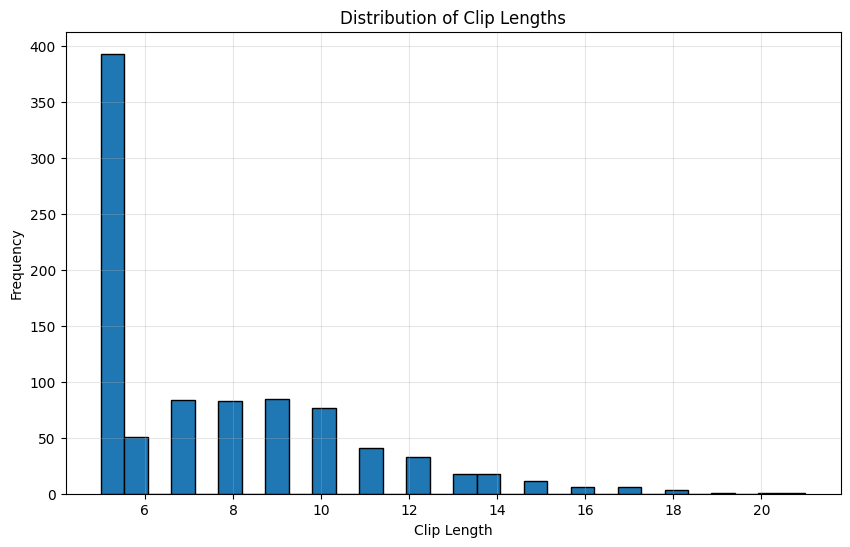

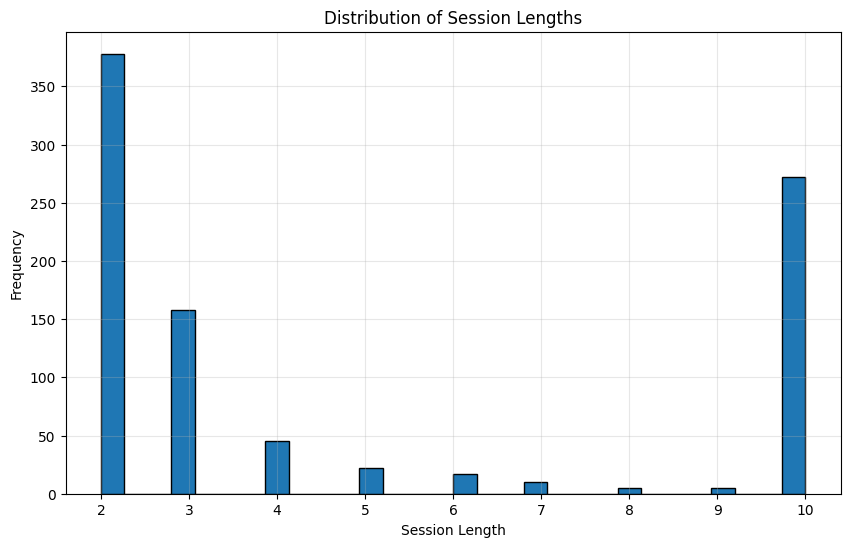

Length 2: 378 samples
Length 3: 158 samples
Length 4: 45 samples
Length 5: 22 samples
Length 6: 17 samples
Length 7: 10 samples
Length 8: 5 samples
Length 9: 5 samples
Length 10: 272 samples


In [1]:
import json
import matplotlib.pyplot as plt

samples = []

with open("data/annotations/sft/small_train_selected.jsonl", "r") as f:
    for line in f:
        samples.append(json.loads(line))

mem_lens = []
for sample in samples:
    mem_len = 0
    for mem in sample["session"][0]:
        mem_len += len(mem)
    mem_lens.append(mem_len)

lens = [len(d["session"][0]) for d in samples]


plt.figure(figsize=(10, 6))
plt.hist(mem_lens, bins=30, edgecolor="black")
plt.xlabel("Clip Length")
plt.ylabel("Frequency")
plt.title("Distribution of Clip Lengths")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(lens, bins=30, edgecolor="black")
plt.xlabel("Session Length")
plt.ylabel("Frequency")
plt.title("Distribution of Session Lengths")
plt.grid(True, alpha=0.3)
plt.show()

# Count frequency of each length
length_counts = {}
for l in lens:
    length_counts[l] = length_counts.get(l, 0) + 1

# Sort by length and print
for length in sorted(length_counts.keys()):
    print(f"Length {length}: {length_counts[length]} samples")